In [53]:

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

#  Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#  Crossvalidation
# ------------------------------------------------------------------------------
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

In [54]:
df=pd.read_csv('../datos/salarios_encoding_dum.csv', index_col=0)
df.head(2) #Hacemos una vista previa de nuestro DataFrame

,salary_box,experience_levelmap_funcion,emp_resid_CA,emp_resid_ES,emp_resid_FR,emp_resid_GB,emp_resid_IN,emp_resid_US
0,4631.904560,1,0,0,0,0,0,1
1,7311.922975,2,0,0,0,0,0,1


El objetivo de este pairprogramming es que hagáis vuestro primer modelo de machine learning. Para eso recordad que:

- Deberéis separar la X y la y.
- Deberéis crear el train y el test.
- Ajustar vuestro modelo.

In [55]:
x = df.drop("salary_box", axis = 1) #Variables predictoras
y = df["salary_box"] #Variable respuesta

In [56]:
# Separamos nuestras variables en test y train.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [57]:
# iniciamos la regresión lineal. n_jobs hace referencia al número de nucleos que usaremos de nuestro ordenador. 
# Al indicar -1 significa que los usaremos todos. 
lr = LinearRegression(n_jobs=-1)

In [58]:
# fiteamos el modelo, lo que significa que le pasamos los datos de entrenamiento para que aprenda el algoritmo. 
# Fijaros que para que aprenda, les paso solo los datos de entrenamiento

lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [59]:
# es el momento de hacer las predicciones, para eso usarmos el método predict() de sklearn 

y_predict_train = lr.predict(x_train) # hacemos las predicciones para los salarios a predecir
y_predict_test = lr.predict(x_test) # hacemos las predicciones para los salarios que tenemos en los datos de test

In [60]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_predict_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_predict_test,  'Set': ['Test']*len(y_test)})
resultados = pd.concat([train_df,test_df], axis = 0)
resultados.head()

,Real,Predicted,Set
109,11171.498346,8478.305073,Train
247,6421.646998,7487.738739,Train
234,3677.054839,3665.571643,Train
202,4860.617969,4090.734704,Train
78,9727.326344,6497.172405,Train


In [61]:
# Vamos a sacar los residuos para verlo más claramente
resultados['residuos'] = resultados['Real'] - resultados['Predicted']
resultados.head(10) 

,Real,Predicted,Set,residuos
109,11171.498346,8478.305073,Train,2693.193273
247,6421.646998,7487.738739,Train,-1066.091741
234,3677.054839,3665.571643,Train,11.483197
202,4860.617969,4090.734704,Train,769.883265
78,9727.326344,6497.172405,Train,3230.153939
147,8533.395515,7487.738739,Train,1045.656775
59,2674.723649,2240.411112,Train,434.312537
118,5460.900086,7487.738739,Train,-2026.838653
6,3385.268560,4022.695527,Train,-637.426966
182,5801.135240,4952.598382,Train,848.536858


En vista de los primeros resultados tenemos unos residuos importantes en nuestro modelo, tanto sobreestimado como infraestimado. Veamos graficamente nuestro modelo pero podemos intuir que va a mal.

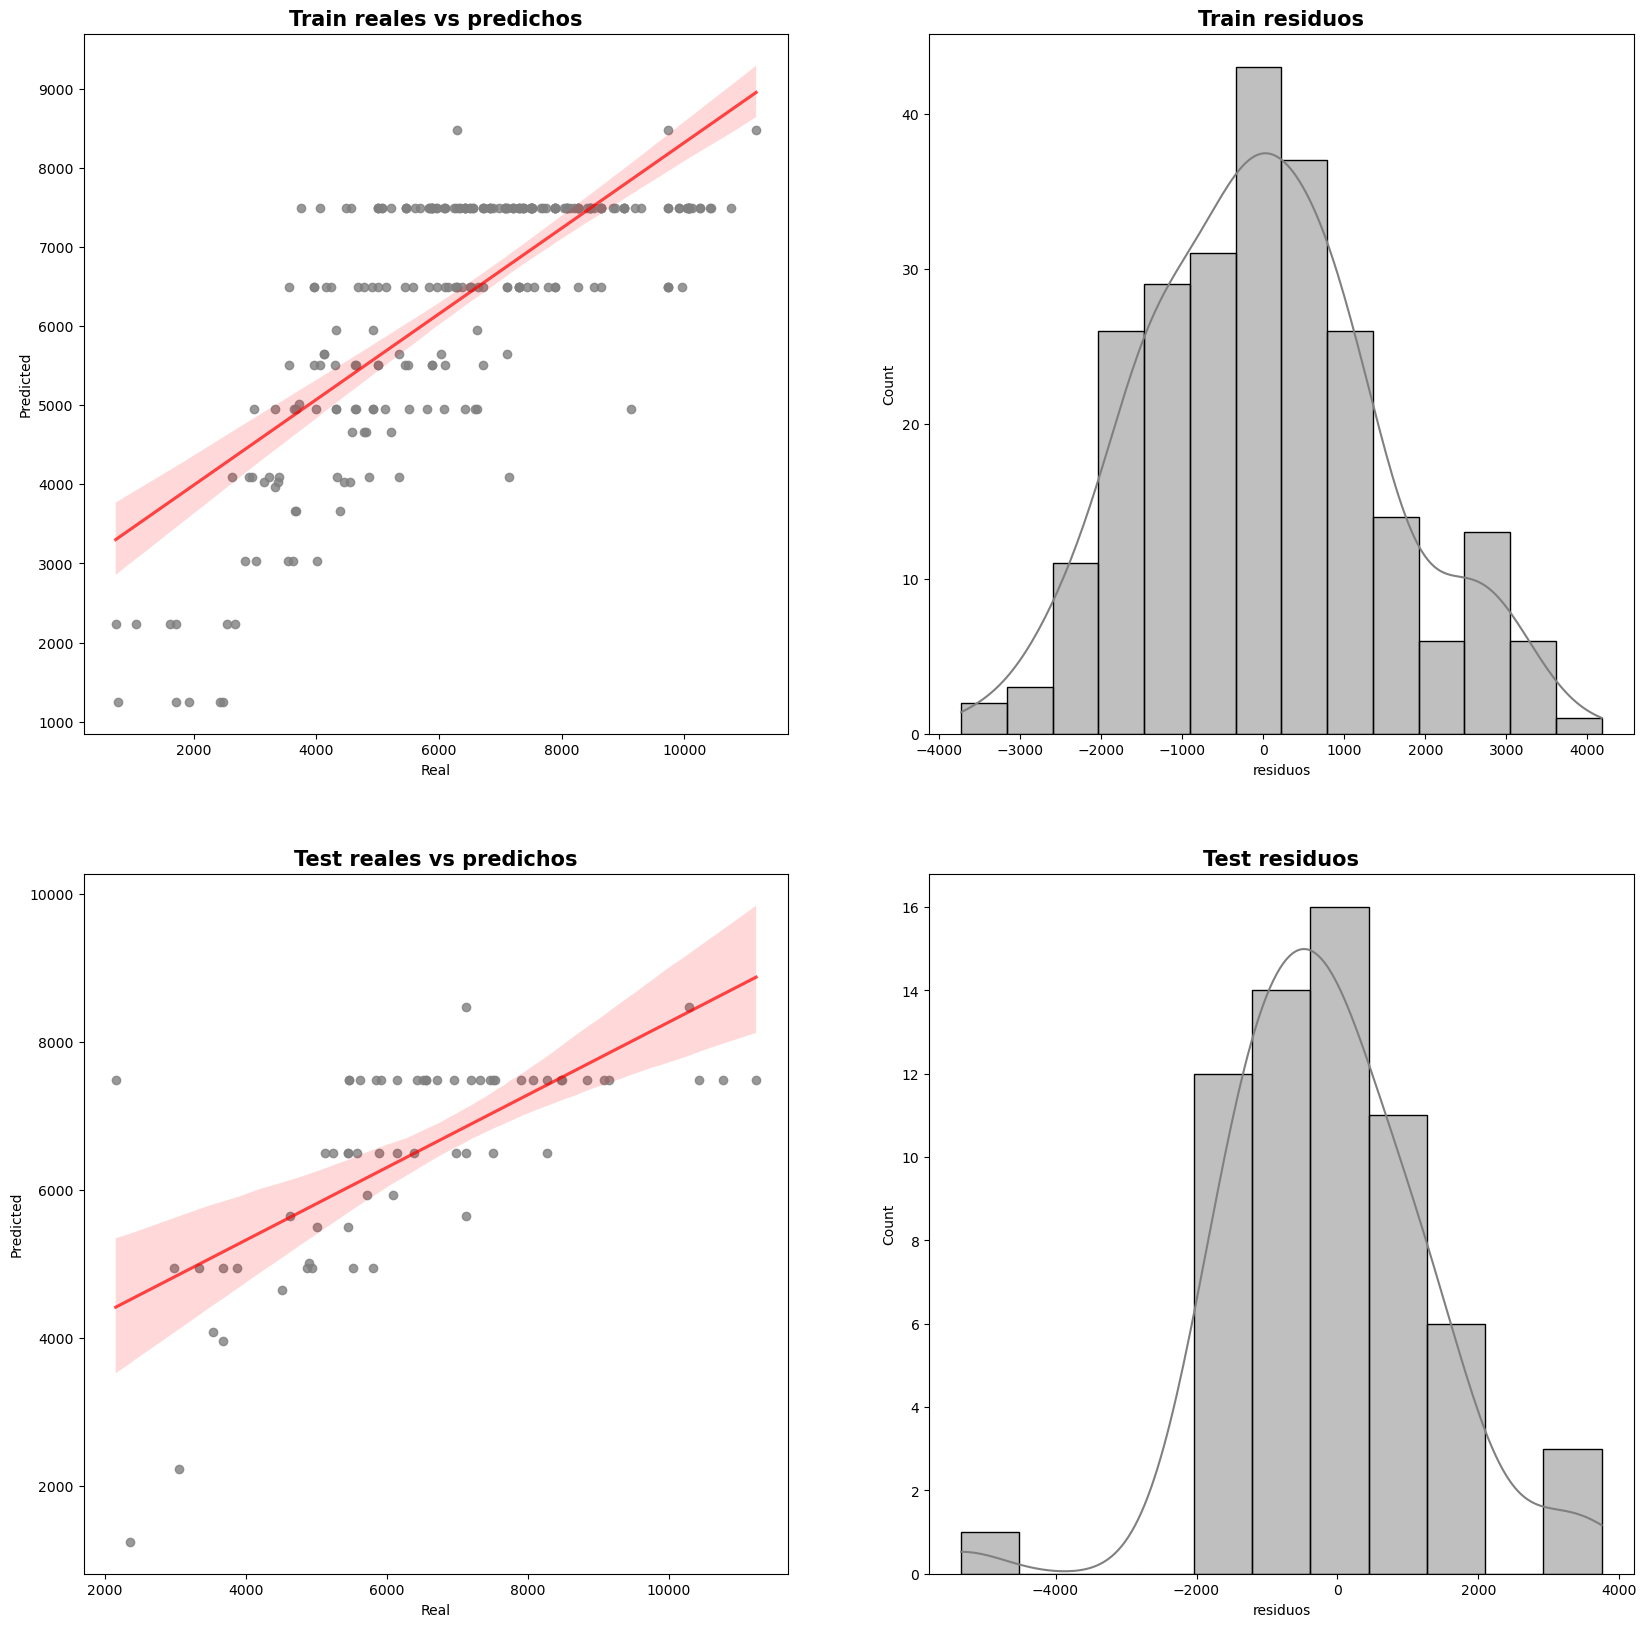

In [62]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = resultados[resultados['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = resultados[resultados['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(resultados[resultados['Set'] == "Train"],
             x="residuos",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(resultados[resultados['Set'] == "Test"],
             x="residuos",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

Efectivamente como sospechabamos nuestros datos no presentan una estructura lineal, sino que vemos franjas muy marcadas como si de categorias se tratara, recordemos que nuestra variable a predecir son salarios. Aunque nuestros datos han cumplido todas las asunciones, este modelo no se adecue a nuestros datos.

 # *Cross-Validation* o Validación cruzada

In [63]:
# Validación cruzada repetida con una única métrica
# ==============================================================================
cv_scores = cross_val_score(
                estimator = LinearRegression(), # que algoritmo  queremos usar para ajustar el modelo
                X         = x, # cuales son las variables X. Fijaos que no le pasamos el X_train, le pasamos todos los datos de la X
                y         = y, # cual es nuestra variable y
                scoring   = 'neg_root_mean_squared_error', # que métrica queremos calcular
                cv        = 10 # número de veces que queremos hacer la validación
             )

print(f"Métricas validación cruzada: {cv_scores}") # sacamos las métricas para cada una de las iteraciones
print(f"Média métricas de validación cruzada: {cv_scores.mean()}") # calculamos la media de todas las iteraciones. 

Métricas validación cruzada: [-1165.15201662 -1205.61799563  -989.92006563 -1360.39891665
 -1509.13742424 -1460.59086289 -1388.74838194 -1736.83864914
 -1664.51128397 -1901.39002303]
Média métricas de validación cruzada: -1438.230561973893


In [64]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'matthews_corrcoef', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_s

In [65]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================

cv_scores = cross_validate(
                estimator = LinearRegression(),
                X         = x,
                y         = y,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = 10)

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.008097,0.002727,0.604788,-1165.152017
1,0.002237,0.001793,0.683626,-1205.617996
2,0.002370,0.001462,0.744847,-989.920066
3,0.002553,0.001566,0.542461,-1360.398917
4,0.002481,0.002000,0.000979,-1509.137424
5,0.003380,0.003174,0.294236,-1460.590863
6,0.002826,0.001807,0.609217,-1388.748382
7,0.002578,0.001753,0.312148,-1736.838649
8,0.002342,0.001423,0.060076,-1664.511284
9,0.002535,0.001464,0.201379,-1901.390023


In [66]:
# calculamos la media para cada una de las métricas

print(f'la media para el r2 es {cv_scores["test_r2"].mean()}')
print(f'la media para el RMSE es {abs(cv_scores["test_neg_root_mean_squared_error"].mean())}')

la media para el r2 es 0.40537574740949545
la media para el RMSE es 1438.230561973893


## Metricas

In [67]:
# Para el conjunto de entrenamsiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_predict_train))
print('El MAE es',mean_absolute_error(y_train,y_predict_train))
print('El MSE es',mean_squared_error(y_train,y_predict_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_predict_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_predict_test))
print('El MAE es',mean_absolute_error(y_test,y_predict_test))
print('El MSE es',mean_squared_error(y_test,y_predict_test))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_predict_test)))

Para el conjunto train:---------------
El valor de r2 score es  0.541285284013261
El MAE es 1152.5791679819936
El MSE es 2117209.872674037
EL RMSE es  1455.0635287416274
Para el conjunto test:---------------
El valor de r2 score es  0.476543315405094
El MAE es 1074.127184322865
El MSE es 2045892.4555392375
EL RMSE es  1430.3469703324565


In [68]:
resultados_metricas = {'MAE': [mean_absolute_error(y_test, y_predict_test), mean_absolute_error(y_train, y_predict_train)],
                'MSE': [mean_squared_error(y_test, y_predict_test), mean_squared_error(y_train, y_predict_train)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_predict_test)), np.sqrt(mean_squared_error(y_train, y_predict_train))],
                'R2':  [r2_score(y_test, y_predict_test), r2_score(y_train, y_predict_train)],
                 "set": ["test", "train"], 
                 "modelo": ["Linear Regresion", "LinearRegression"]}

df_resultados = pd.DataFrame(resultados_metricas)

df_resultados

,MAE,MSE,RMSE,R2,set,modelo
0,1074.127184,2.045892e+06,1430.346970,0.476543,test,Linear Regresion
1,1152.579168,2.117210e+06,1455.063529,0.541285,train,LinearRegression


In [69]:
# vamos a guardar este csv para usarlo en próximas lecciones

df_resultados.to_csv("../datos/resultados_salarys.csv")